# COVID-19 Infection Risk Prediction with Amazon SageMaker Autopilot

---

## Contents

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#SetupAPjob)
1. [Autopilot Results](#Results)
1. [Batch Inference](#BatchInf)
1. [Cleanup](#Cleanup)


---

## Introduction

Amazon SageMaker Autopilot is an automated machine learning (commonly referred to as AutoML) solution for tabular datasets. You can use SageMaker Autopilot in different ways: on autopilot (hence the name) or with human guidance, without code through SageMaker Studio, or using the AWS SDKs. This notebook, as a first glimpse, will use the AWS SDKs to simply create and deploy a machine learning model.

Coronavirus disease (COVID-19) is an infectious disease caused by a new virus. People can catch COVID-19 from others who have the virus. While we are still learning about how COVID-19 affects people, older persons and persons with pre-existing medical conditions (such as high blood pressure, heart disease, lung disease, cancer or diabetes) appear to develop serious illness more often than others.

In this notebook we are going to demonstrate how we can use AutoPilot to create a model to predict COVID-19 infection risk based on various factors like age, sex, country, present medical conditions, number of people contacted with, steps taken by the government to contain the risk, etc.   

---
## Setup


Import the required libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import json
import math
import time
import datetime
import s3fs
import boto3
import sagemaker
import io
from datetime import timedelta
import sagemaker
import boto3
from sagemaker import get_execution_role

The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [2]:
region = boto3.Session().region_name

session = sagemaker.Session()

# You can modify the following to use a bucket of your choosing
bucket = session.default_bucket()
prefix = 'sagemaker/DEMO-autopilot-covid19'

role = get_execution_role()

# This is the client we will use to interact with SageMaker AutoPilot
sm = boto3.Session().client(service_name='sagemaker',region_name=region)

## Data

We are going to use the data which is generated by a public survey which captures various data like age, sex, country, health conditions and other relevant data along with labels like probability of covid-19 infection and mortality. In this example we are going to use probability of covid-19 infection (column name: risk_infection) as our target column.

The dataset we use is publicly available at https://www.covid19survivalcalculator.com/download. 

In [3]:
#download the csv file to local
!wget https://www.covid19survivalcalculator.com/data/master_dataset.csv

--2020-05-04 12:19:55--  https://www.covid19survivalcalculator.com/data/master_dataset.csv
Resolving www.covid19survivalcalculator.com (www.covid19survivalcalculator.com)... 13.225.249.54, 13.225.249.72, 13.225.249.86, ...
Connecting to www.covid19survivalcalculator.com (www.covid19survivalcalculator.com)|13.225.249.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113862767 (109M) [application/vnd.ms-excel]
Saving to: ‘master_dataset.csv’

master_dataset.csv  100%[===================>] 108.59M  11.3MB/s    in 10s     

2020-05-04 12:20:06 (10.6 MB/s) - ‘master_dataset.csv’ saved [113862767/113862767]



In [4]:
# capture only the columns 
df = pd.read_csv('master_dataset.csv', nrows=0)
tempheaderdf = pd.DataFrame(df)
tempheaderdf.columns

Index(['survey_date', 'region', 'country', 'ip_latitude', 'ip_longitude',
       'ip_accuracy', 'sex', 'age', 'height', 'weight', 'bmi', 'blood_type',
       'smoking', 'alcohol', 'cannabis', 'amphetamines', 'cocaine', 'lsd',
       'mdma', 'contacts_count', 'house_count', 'text_working',
       'rate_government_action', 'rate_reducing_risk_single',
       'rate_reducing_risk_house', 'rate_reducing_mask', 'covid19_positive',
       'covid19_symptoms', 'covid19_contact', 'asthma', 'kidney_disease',
       'compromised_immune', 'heart_disease', 'lung_disease', 'diabetes',
       'hiv_positive', 'hypertension', 'other_chronic',
       'prescription_medication', 'opinion_infection', 'opinion_mortality',
       'risk_infection', 'risk_mortality'],
      dtype='object')

In [5]:
# read the rows, assign column names to the data and drop columns we are not going to use in this notebook 
#(you can modify this notebook to suit your needs)
df = pd.read_csv('master_dataset.csv', parse_dates=True, header=None, skiprows=[0])
pd.set_option('display.max_columns', 50)
df.drop(df.columns[[43]], axis = 1, inplace = True)
df.columns = tempheaderdf.columns
df.drop(['survey_date', 'region', 'ip_accuracy', 'prescription_medication', 'risk_mortality'], axis = 1, inplace = True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Following are the columns we are going to use for this notebook:
- `country`: two-letter abbreviation for country; for example, US or GB
- `ip_latitude`: IP location latitude randomly adjusted (-0.1 to +0.1) as per the download website
- `ip_longitude`: IP location longitude randomly adjusted (-0.1 to +0.1) as per the download website
- `sex`: Sex of the individual
- `age`: Age of the individual reduced to 10-year bandings as per the download website
- `height`: Height of the individual
- `weight`: Weight of the individual
- `bmi`: BMI (Body Mass Index) of the individual
- `blood_type`: Blood group
- `smoking`: Does the individual smoke or not
- `alcohol`: Does the individual consume alcohol or not
- `cannabis`: Does the individual use Non-Prescription Drugs (cannabis) or not
- `amphetamines`: Does the individual use Non-Prescription Drugs (amphetamines) or not
- `cocaine`: Does the individual use Non-Prescription Drugs (cocaine) or not
- `lsd`: Does the individual use Non-Prescription Drugs (lsd) or not
- `mdma`: Does the individual use Non-Prescription Drugs (mdma) or not
- `contacts_count`: How many people was the individual in close contact with in the last week? (including partners, children, work colleagues, customers, patients etc.)
- `house_count`: How many people live in individual's house / flat
- `text_working`: Are traveling to work / school?
- `rate_government_action`: Is the individual's country's government taking COVID-19 seriously
- `rate_reducing_risk_single`: Is the individual taking steps to reduce his/her risk (social distancing, washing hands).
- `rate_reducing_risk_house`: Do the people the individual live with are taking steps to reduce risk (social distancing, washing hands).
- `rate_reducing_mask`: Does the individual wear a mask when outside of house / flat?
- `covid19_positive`: Is the individual covid19 positive
- `covid19_symptoms`: Does the individual have covid19 symptoms (dry cough, fever, breathlessness etc)
- `covid19_contact`: Is the individual come in contact with a person having covid19
- `asthma`: Does the individual have asthma
- `kidney_disease`: Does the individual have kidney disease
- `compromised_immune`: Does the individual have compromised immune system
- `heart_disease`: Does the individual have heart disease
- `lung_disease`: Does the individual have lung disease
- `diabetes`: Does the individual have diabetes
- `hiv_positive`: Is the individual hiv positive
- `hypertension`: Does the individual have hypertension
- `other_chronic`: Does the individual have any other chronic
- `opinion_infection`: Individual's own opinion of his/her chances of getting COVID-19
- `opinion_mortality`: Individual's own opinion of his/her chances of dying if they have COVID-19
- `risk_infection`: Probaility of getting infected with COVID-19 (<b>Target Attribute/Column</b>)


In [6]:
df.head()

,country,ip_latitude,ip_longitude,sex,age,height,weight,bmi,blood_type,smoking,alcohol,cannabis,amphetamines,cocaine,lsd,mdma,contacts_count,house_count,text_working,rate_government_action,rate_reducing_risk_single,rate_reducing_risk_house,rate_reducing_mask,covid19_positive,covid19_symptoms,covid19_contact,asthma,kidney_disease,compromised_immune,heart_disease,lung_disease,diabetes,hiv_positive,hypertension,other_chronic,opinion_infection,opinion_mortality,risk_infection
0,CA,43.7626,-79.4654,male,20_30,178,88,27.7,bn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,9.0
1,CA,43.2440,-79.8536,male,80_90,184,94,27.7,an,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1,0,0,NaN,0,0,0,0,0,1,0,1,1,0,1,0,NaN,NaN,9.0
2,CA,51.1195,-113.9604,female,30_40,158,54,21.6,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,9.0
3,CA,45.5180,-73.6985,male,60_70,172,96,32.4,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,0,1,0,1,0,NaN,NaN,9.0
4,CA,48.4194,-123.4261,female,50_60,166,82,29.7,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1,0,0,NaN,0,0,0,0,0,1,0,0,0,0,0,1,NaN,NaN,9.0


In [7]:
df.shape

(692295, 38)

Analyze the distribution of the data for the target column

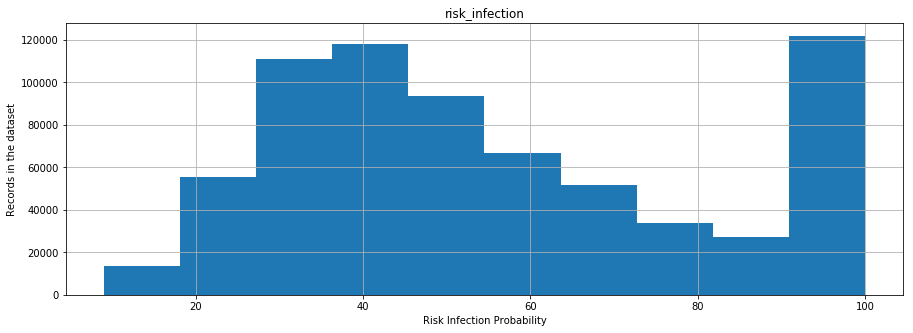

In [8]:
axarr = df.hist(column='risk_infection', figsize=(15,5))
for ax in axarr.flatten():
    ax.set_xlabel("Risk Infection Probability")
    ax.set_ylabel("Records in the dataset")

### Preparing data for training and testing

Divide the data into training and testing splits. The training split is used by SageMaker Autopilot. The testing split will be used for inference.

In [9]:
train_data = df.sample(frac=0.8,random_state=200)
test_data = df.drop(train_data.index)
#Drop the target column from the test data
test_data_no_target = test_data.drop(columns=['risk_infection'])

print('Total Record Count of the Dataset: ' + str(df.shape[0]))
print('Training Data Record Count: ' + str(train_data.shape[0]))
print('Testing Data Record Count: ' + str(test_data.shape[0]))

Total Record Count of the Dataset: 692295
Training Data Record Count: 553836
Testing Data Record Count: 138459


Upload the training and test files to S3 locations

In [10]:
train_file = 'train_data.csv';
train_data.to_csv(train_file, index=False, header=True)
train_data_s3_path = session.upload_data(path=train_file, key_prefix=prefix + "/train")
print('Train data uploaded to: ' + train_data_s3_path)

test_file = 'test_data.csv';
test_data_no_target.to_csv(test_file, index=False, header=False)
test_data_s3_path = session.upload_data(path=test_file, key_prefix=prefix + "/test")
print('Test data uploaded to: ' + test_data_s3_path)

Train data uploaded to: s3://sagemaker-ap-south-1-730038224500/sagemaker/DEMO-autopilot-covid19/train/train_data.csv
Test data uploaded to: s3://sagemaker-ap-south-1-730038224500/sagemaker/DEMO-autopilot-covid19/test/test_data.csv


## Setting up the SageMaker Autopilot Job<a name="SetupAPjob"></a>

After uploading the dataset to Amazon S3, you can invoke Autopilot to find the best ML pipeline to train a model on this dataset. 

The required inputs for invoking a Autopilot job are:
* Amazon S3 location for input dataset and for all output artifacts
* Name of the column of the dataset you want to predict (`risk_infection` in this case) 
* An IAM role

Currently Autopilot supports only tabular datasets in CSV format. Either all files should have a header row, or the first file of the dataset, when sorted in alphabetical/lexical order by name, is expected to have a header row.

You can also specify the type of problem you want to solve with your dataset (`Regression, MulticlassClassification, BinaryClassification`). In case you are not sure, SageMaker Autopilot will infer the problem type based on statistics of the target column (the column you want to predict). 

Because the target attribute, ```risk_infection```, is a real value, our model will be performing regression. In this example we will let AutoPilot infer the type of problem for us.

You have the option to limit the running time of a SageMaker Autopilot job by providing either the maximum number of pipeline evaluations or candidates (one pipeline evaluation is called a `Candidate` because it generates a candidate model) or providing the total time allocated for the overall Autopilot job. Under default settings, this job takes about four hours to run. This varies between runs because of the nature of the exploratory process Autopilot uses to find optimal training parameters.

In [11]:
input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/train'.format(bucket,prefix)
        }
      },
      'TargetAttributeName': 'risk_infection'
    }
  ]

output_data_config = {
    'S3OutputPath': 's3://{}/{}/output'.format(bucket,prefix)
  }

### Launching the SageMaker Autopilot Job

You can now launch the Autopilot job by calling the `create_auto_ml_job` API. We limit the number of candidates to 20 so that the job finishes in a few minutes.

In [12]:
from time import gmtime, strftime, sleep
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

auto_ml_job_name = 'automl-covid19-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig={'CompletionCriteria':
                                       {'MaxCandidates': 20}
                                      },
                      RoleArn=role)

AutoMLJobName: automl-covid19-04-12-20-35


{'AutoMLJobArn': 'arn:aws:sagemaker:ap-south-1:730038224500:automl-job/automl-covid19-04-12-20-35',
 'ResponseMetadata': {'RequestId': 'ffcb9acb-e1c5-4908-99f5-1aaec7b0e7ef',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ffcb9acb-e1c5-4908-99f5-1aaec7b0e7ef',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '98',
   'date': 'Mon, 04 May 2020 12:20:35 GMT'},
  'RetryAttempts': 0}}

### Tracking SageMaker Autopilot job progress
SageMaker Autopilot job consists of the following high-level steps : 
* Analyzing Data, where the dataset is analyzed and Autopilot comes up with a list of ML pipelines that should be tried out on the dataset. The dataset is also split into train and validation sets.
* Feature Engineering, where Autopilot performs feature transformation on individual features of the dataset as well as at an aggregate level.
* Model Tuning, where the top performing pipeline is selected along with the optimal hyperparameters for the training algorithm (the last stage of the pipeline). 

In [13]:
print ('JobStatus - Secondary Status')
print('------------------------------')


describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)

JobStatus - Secondary Status
------------------------------
InProgress - Starting
InProgress - Starting
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InPro

---
## Results

Use the `describe_auto_ml_job` API to look up the best candidate selected by the SageMaker Autopilot job based on the objective metric selected by SageMaker AutoPilot

In [14]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
print(best_candidate)
print('\n')
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

{'CandidateName': 'tuning-job-1-fbe19de184b6495b8c-005-c3ee1078', 'FinalAutoMLJobObjectiveMetric': {'MetricName': 'validation:mse', 'Value': 2.040479898452759}, 'ObjectiveStatus': 'Succeeded', 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob', 'CandidateStepArn': 'arn:aws:sagemaker:ap-south-1:730038224500:processing-job/db-1-f6d40eab766248c3ae7fd02ff20246b0bd61f29229284d279074ddf492', 'CandidateStepName': 'db-1-f6d40eab766248c3ae7fd02ff20246b0bd61f29229284d279074ddf492'}, {'CandidateStepType': 'AWS::SageMaker::TrainingJob', 'CandidateStepArn': 'arn:aws:sagemaker:ap-south-1:730038224500:training-job/automl-cov-dpp7-1-542cf254555f416399a2e3712959fb370df252dd89334', 'CandidateStepName': 'automl-cov-dpp7-1-542cf254555f416399a2e3712959fb370df252dd89334'}, {'CandidateStepType': 'AWS::SageMaker::TransformJob', 'CandidateStepArn': 'arn:aws:sagemaker:ap-south-1:730038224500:transform-job/automl-cov-dpp7-rpb-1-461dc945a1894780b493a73805dc059f726a5933a', 'CandidateStepName'

---
## Batch inference using the best candidate<a name="BatchInf"></a>

Create a model using the best candidate selected by SageMaker AutoPilot and create a batch transform job as our test data has more than 100K records.

In [15]:
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
model_name = best_candidate_name + timestamp_suffix + "-model"
model_arn = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)
print('Model ARN corresponding to the best candidate is : {}'.format(model_arn['ModelArn']))

Model ARN corresponding to the best candidate is : arn:aws:sagemaker:ap-south-1:730038224500:model/tuning-job-1-fbe19de184b6495b8c-005-c3ee107804-13-13-44-model


In [16]:
transform_job_name = 'automl-covid19-transform-' + timestamp_suffix

transform_input = {
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': test_data_s3_path
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    }

transform_output = {
        'S3OutputPath': 's3://{}/{}/inference-results'.format(bucket,prefix),
    }

transform_resources = {
        'InstanceType': 'ml.m5.4xlarge',
        'InstanceCount': 1
    }

sm.create_transform_job(TransformJobName = transform_job_name,
                        ModelName = model_name,
                        TransformInput = transform_input,
                        TransformOutput = transform_output,
                        TransformResources = transform_resources
)

{'TransformJobArn': 'arn:aws:sagemaker:ap-south-1:730038224500:transform-job/automl-covid19-transform-04-13-13-44',
 'ResponseMetadata': {'RequestId': '635a2387-4b6e-4414-87da-8ee41aed5af9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '635a2387-4b6e-4414-87da-8ee41aed5af9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '114',
   'date': 'Mon, 04 May 2020 13:13:45 GMT'},
  'RetryAttempts': 0}}

Check for Job status

In [17]:
print ('JobStatus')
print('----------')


describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
job_run_status = describe_response['TransformJobStatus']
print (job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
    job_run_status = describe_response['TransformJobStatus']
    print (job_run_status)
    sleep(30)

JobStatus
----------
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


View the results of the transform job.

In [18]:
s3_output_key = '{}/inference-results/test_data.csv.out'.format(prefix);
local_inference_results_path = 'inference_results.csv'

s3 = boto3.resource('s3')
inference_results_bucket = s3.Bucket(session.default_bucket())

inference_results_bucket.download_file(s3_output_key, local_inference_results_path);

inference_data = pd.read_csv(local_inference_results_path, sep=';', header=None)
#Keep the output on one page
pd.set_option('display.max_rows', 10)
inference_data

,0
0,9.191731
1,9.105079
2,9.425474
3,8.632153
4,14.490453
...,...
138454,92.199959
138455,40.414062
138456,82.357780
138457,45.973705


If you are performing regression for a continuous value (i.e.linear regression) then you may use metrics such as MSE (mean square error) or RMSE (root mean square error) for evaluating the accuracy of a linear regression model. In our case we will use MSE. AutoPilot has also selected the best model based on MSE.

In [19]:
MSE = np.square(np.subtract(test_data.reset_index()['risk_infection'],inference_data[0])).mean()
print('Mean Square Error: {0:.2f}'.format(MSE))

Mean Square Error: 1.92


Apart from the MSE calculation, visualization in form of charts gives us a better idea about the model. In this case we have ploted the line graphs for the true values vs predicted values. For better readability we have plotted the last 100 values. However keep in mind that the MSE is calculated for the complete test dataset

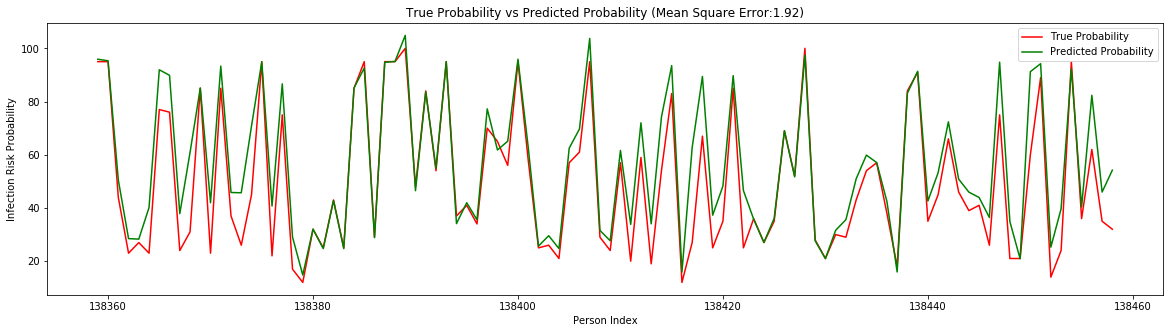

In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

plt.plot(test_data.reset_index().tail(100).index.values, test_data.reset_index()['risk_infection'].tail(100), color = "red")
plt.plot(test_data.reset_index().tail(100).index.values, inference_data[0].tail(100), color = "green")
plt.title("True Probability vs Predicted Probability (Mean Square Error:{0:.2f})".format(MSE))
plt.xlabel("Person Index")
plt.ylabel("Infection Risk Probability")
plt.legend(['True Probability','Predicted Probability'])
plt.show()

---
## Cleanup

The Autopilot job creates many underlying artifacts such as dataset splits, preprocessing scripts, or preprocessed data, etc. This code, when un-commented, deletes them. This operation deletes all the generated models and the auto-generated notebooks as well. 

In [21]:
#s3 = boto3.resource('s3')
#s3_bucket = s3.Bucket(bucket)

#job_outputs_prefix = '{}/output/{}'.format(prefix, auto_ml_job_name)
#s3_bucket.objects.filter(Prefix=job_outputs_prefix).delete()